<html>
 <head>
 </head>
 <body>
          <div class="alert alert-block alert-info" style="color:darkgreen;font-size:25px;text-align:center">
         <b>Interactive map of Deforestation Simulation</b>
     </div>
                    <p style="text-align:center"> Python 3.9</p>
               <p style="text-align:center"> February 2023 </p>
     <br/>
     <p><b>NOTE</b> local hyperlink (for table of content) does not work in Github ipynb file the same way in Notebook. Just scroll down </p>
     <br/>
     <a id='content'></a>
     <p style="color:blue"> <b>Contents:</b> </p>
     <a href="#1."> 1. Libraries</a><br/>
     <a href="#2."> 2. Data: Vector and Raster</a><br/>
     <a href="#3."> 3. Data pre-processing</a><br/>
     <a href="#4."> 4. Deforestation simulation by Machine Learning</a><br/>
     <a href="#5."> 5. Interactive map</a><br/>
     <a href="#6."> 6. Publish map at Datapane.com</a><br/>
     <br/>
 </body>
</html>

<html>
 <head>
 </head>
 <body>
          <a id='1.'></a>
     <p style="color:blue;font-size:20px"> 1. Libraries</p>
     <br/>
 </body>
</html>

In [1]:
# libraries for processing spatial data

import geopandas as gpd
import pandas as pd
import numpy as np

In [ ]:
from osgeo import gdal, ogr

In [2]:
import shapely

In [3]:
# librari for visualisation

import folium
from folium.plugins import TimestampedGeoJson
import matplotlib.pyplot as plt

# to add marker on Folium map
import base64
from folium import IFrame

In [4]:
import datapane as dp

In [5]:
import random

WD = '/Path/'

<html>
 <head>
 </head>
 <body>
          <a id='2.'></a>
     <p style="color:blue;font-size:20px"> 2. Data</p>
     <br/>
     <p>Vector data has 2 main classes/trails: 1) logging trails and 2) road/river</p>
     <p>&emsp; - the 'Order' attribute represent the time order in time series: 0 - 4</p>
     <p>&emsp; - Only logging trails that has dynamic time order (1 - 4)</p>
     <p>&emsp; - road/river network is set to static: timer order = 0</p>
     <br/>
     <p>Raster is a CHM (Canopy Height Model) which represent forest height in the year 2000</p>
     <p>&emsp; - higher CHM represent taller forest, which is over 35 m height</p>
     <br/>
 </body>
</html>

In [10]:
# load the vector file

gdf = gpd.read_file(WD + 'track_sim.shp')

# rename the header
gdf.rename(columns ={'Jenis':'trails', 'waktu':'Order'}, inplace=True)
gdf.head()

,Id,trails,Order,geometry
0,0.0,logging track 1,2,"LINESTRING (200173.331 131353.196, 200543.737 ..."
1,0.0,logging track 1,4,"LINESTRING (200148.191 130426.737, 200755.523 ..."
2,0.0,logging track 1,4,"LINESTRING (203841.563 132095.234, 203810.278 ..."
3,0.0,logging track 1,2,"LINESTRING (205045.691 132764.490, 205351.025 ..."
4,0.0,logging track 1,2,"LINESTRING (205919.982 133211.646, 206110.190 ..."


In [15]:
# load the raster file

raster = gdal.Open(WD + 'CHM-00.tif')
raster_band = raster.GetRasterBand(1).ReadAsArray() # the tif file has only 1 band

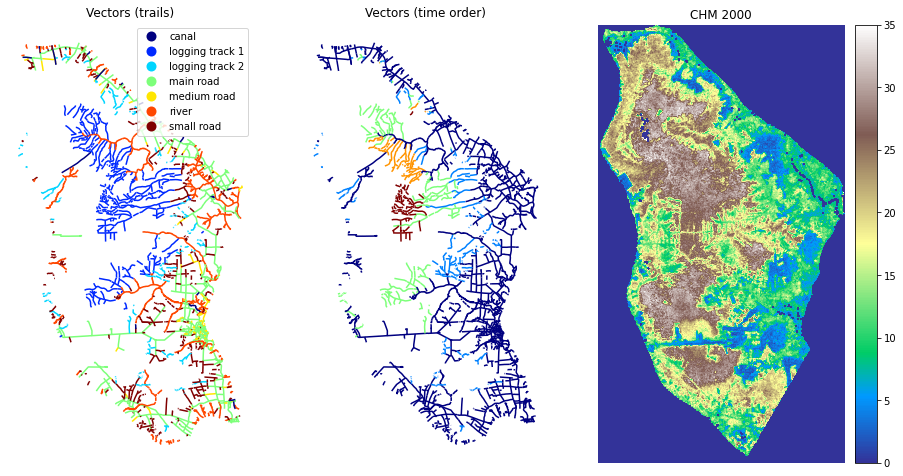

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 10))

gdf.plot(ax=ax1, column='trails', cmap='jet', legend=True)
ax1.set_title('Vectors (trails)')
ax1.axis('off')

gdf.plot(ax=ax2, column='Order', cmap='jet')
ax2.set_title('Vectors (time order)')
ax2.axis('off')

temp = ax3.imshow(raster_band, cmap='terrain', vmin=0, vmax=35)
ax3.set_title('CHM 2000')
ax3.axis('off')

cax = fig.add_axes([ax3.get_position().x1+0.01,
                    ax3.get_position().y0,0.02,ax3.get_position().height])
plt.colorbar(temp, cax=cax) 

This is just the preview of logging trails over time, so ignore the poor quality. Better animation is in interactive map down bellow

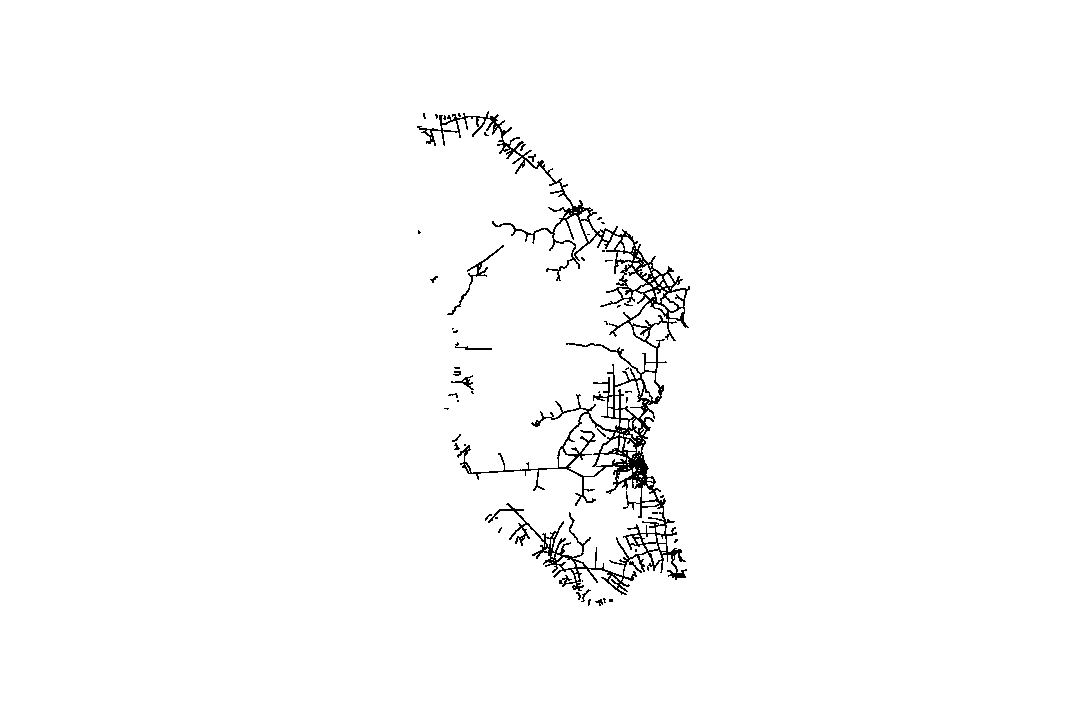

<html>
 <head>
 </head>
 <body>
          <a id='3.'></a>
     <p style="color:blue;font-size:20px"> 3. Data pre-processing</p>
     <br/>
     <p> Use GDAL Python API to rasterise vector <code>gdal.RasterizeLayer()</code> and to calculate proximity raster <code>gdal.ComputeProximity()</code> </p>
     <p>&emsp; - <a href="https://opensourceoptions.com/blog/use-python-to-convert-polygons-to-raster-with-gdal-rasterizelayer/"  target="_blank">Reference</a> for GDAL processing</p>
     <p>&emsp; - rasterised vector is needed to calculate proximity raster</p>
     <p>&emsp; - each pixel in proximity raster represent the distance form that pixel to the nearest logging trails or road/river</p>
     <br/>
 </body>
</html>

In [26]:
# load rasterised vectors

raster_2 = gdal.Open(WD + 'track_ts.tif')
raster_2_band = raster_2.GetRasterBand(1).ReadAsArray() # the tif file has only 1 band

raster_3 = gdal.Open(WD + "L_road.tif")
raster_3_band = raster_3.GetRasterBand(1).ReadAsArray()

(-0.5, 3156.5, 5619.5, -0.5)

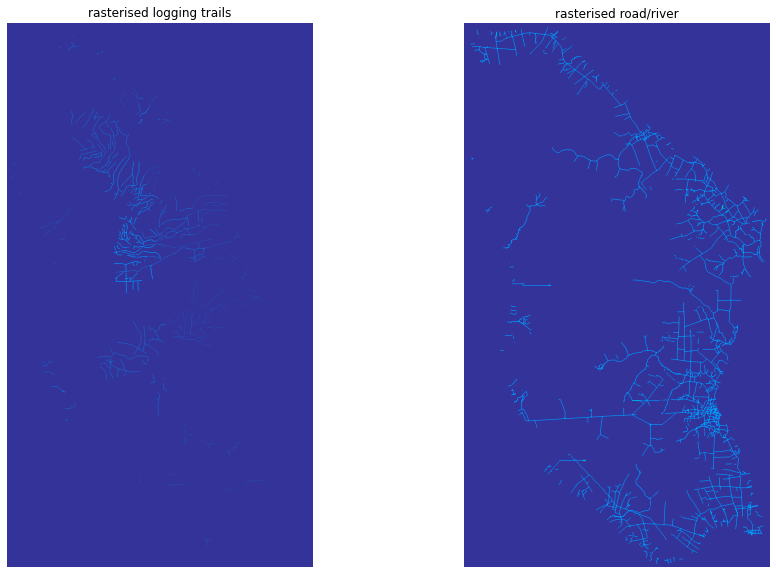

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))

ax1.imshow(raster_2_band, cmap='terrain')
ax1.set_title('rasterised logging trails')
ax1.axis('off')

ax2.imshow(raster_3_band, cmap='terrain')
ax2.set_title('rasterised road/river')
ax2.axis('off')

In [31]:
# load proximity rasters

raster_4 = gdal.Open(WD + "prox-TS.tif")
prox_raster_log = raster_4.ReadAsArray()

raster_5 = gdal.Open(WD + "dist_L_road.tif")
prox_raster_road = raster_5.GetRasterBand(1).ReadAsArray()

(-0.5, 3156.5, 5619.5, -0.5)

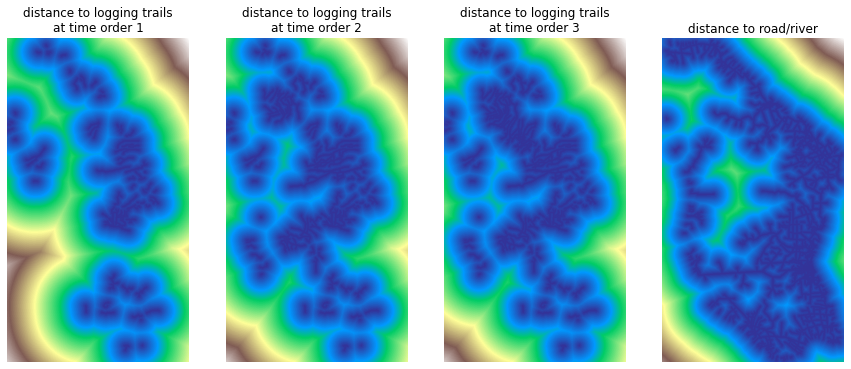

In [37]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 10))

for i in range(0,3):
    axes[i].imshow(prox_raster_log[i], cmap='terrain')
    axes[i].set_title(f'distance to logging trails\nat time order {str(i+1)}')
    axes[i].axis('off')

axes[3].imshow(prox_raster_road, cmap='terrain')
axes[3].set_title(f'distance to road/river')
axes[3].axis('off')

<html>
 <head>
 </head>
 <body>
          <a id='4.'></a>
     <p style="color:blue;font-size:20px"> 4. Deforestation simulation by Machine Learning</p>
     <p>Intuitively, area that are close to road and logging tracks has high risk of deforestation </p>
     <p>&emsp; - there are plenti of way to perform this, either by simple regression or machine learning</p>
     <p></p>
     <br/>
 </body>
</html>

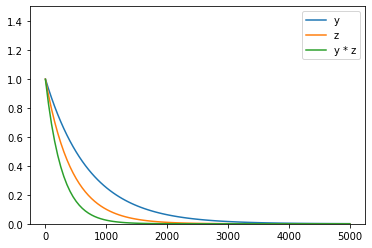

In [38]:
x = np.linspace(1, 5000, 100)
y = (1 / 4)**(x/1000)
z = (1 / 10)**(x/1000)
zz = y*z

#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plt.plot(x, y, label='y')
plt.plot(x, z, label='z')
plt.plot(x, zz, label='y * z')
plt.ylim(0, 1.5)
plt.legend()

plt.show()

<html>
 <head>
 </head>
 <body>
     <p>The above graph ilustrate the effect of logging trails/road/river over distance (x axis in meter)</p>
     <p>&emsp; - deforestation is represented by CHM loss, or loss of canopy height model</p>
     <p>&emsp; - y axis can be set as coefficient factor for CHM loss; the closer to the logging trails/road, the higher coefficient factor for deforestation </p>
     <p>&emsp; - the curve can be manipulated to have different treshold, e.g., either at 1 or 2 km, and either it is smooth or abrupt treshold</p>
     <p>&emsp; - the setting for this simulation (treshold, explanatory variables, ect) is based on my paper that is currently under preparation for publication</p>
     <p></p>
     <br/>
 </body>
</html>

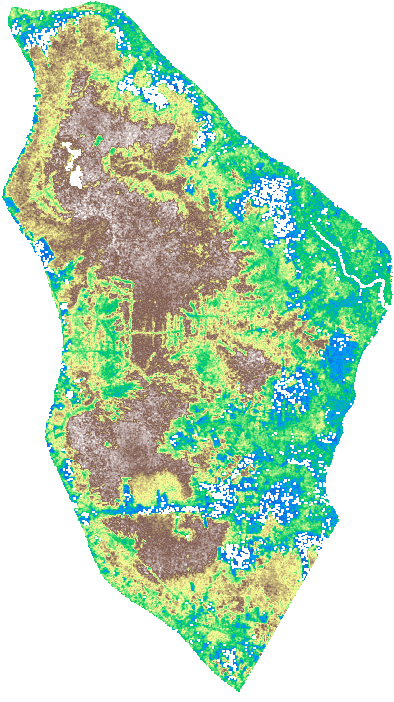

<html>
 <head>
 </head>
 <body>
          <a id='5.'></a>
     <p style="color:blue;font-size:20px"> 5. Interactive map with Folium</p>
     <p></p>
     <br/>
 </body>
</html>

In [7]:
# time series map

m = folium.Map(location=[1.1161120915099632, 102.39364522516243], zoom_start=10)

# Add  vector data in GeoJson format
# Geojson data need 'times' attribute with the correct format e.g. YYYY-MM-DD
# 'style' atribute is recomended for beter visualisation

geojson_log = gdf[['geometry','times', 'style']].to_json()

TimestampedGeoJson(
    geojson_log,
    period = 'P1Y',
    date_options='YYYY',
    transition_time=900,
    add_last_point=False,
).add_to(m)


geojson_road = road[['geometry','times', 'color']].to_json()

folium.GeoJson(
    geojson_road,
    name='Road-river network',
    style_function=lambda feature: {
        'color': feature['properties']['color'],
        'weight': 0.5 
    }
).add_to(m)

In [ ]:
img = folium.raster_layers.ImageOverlay(
    name="Deforestation simulation",
    image=WD+'tes_def_sim.gif',
    bounds=[[0.9118912331078923, 102.2046745008668], [1.420091366130001, 102.48864215332074]],
    interactive=True,
    cross_origin=False,
    zindex=1,
)

# folium.Popup("I am an image").add_to(img)

img.add_to(m)
folium.LayerControl().add_to(m)

m

In [16]:
m.save(WD + 'Def_simulation_map.html')

<html>
 <head>
 </head>
 <body>
          <a id='6.'></a>
     <p style="color:blue;font-size:20px"> 6. Publish map at Datapane.com</p>
     <p><a href="https://docs.datapane.com/install-datapane/"  target="_blank">Reference</a> for Installation datapane library</p>
     <p>&emsp; - published map is available here at <a href="https://cloud.datapane.com/reports/9Ax5nQ3/deforestation-simulation/"  target="_blank">Datapane</a></p>
     <br/>
 </body>
</html>

In [10]:
app = dp.App(dp.Plot(m))
app.upload(name="Deforestation Simulation")

Uploading report and associated data - *please wait...*

Uploading files


Report successfully uploaded - view and share at <a href='https://cloud.datapane.com/reports/9Ax5nQ3/deforestation-simulation/' target='_blank'>here</a>.

<html>
 <head>
 </head>
 <body>
     <p>This is just a preview with low resolution to keep the notebook file small. Go to <a href="https://cloud.datapane.com/reports/9Ax5nQ3/deforestation-simulation/"  target="_blank">Datapane.com</a> for interactive map with better quality</p>
     <br/>
 </body>
</html>

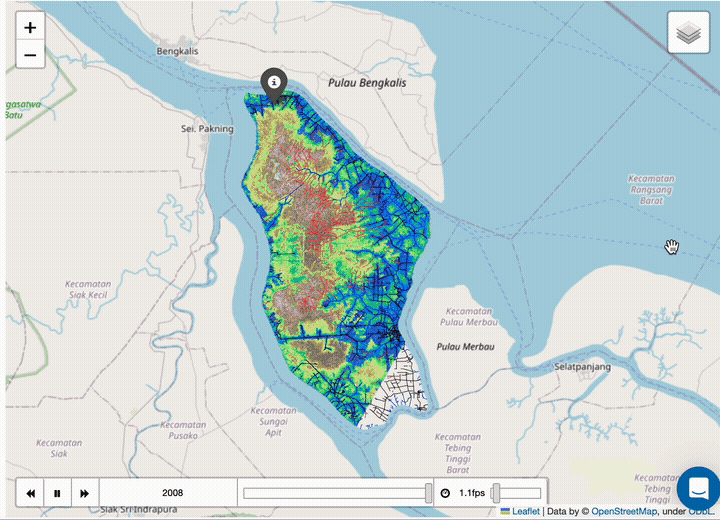